In [1]:
library(dplyr)
library(stringr)
library(readr)
library(tidyr)
library(caret)
library(ggplot2)
library(igraph)
library(ggraph)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice

Loading required package: ggplot2


Attaching package: ‘igraph’


The following object is masked from ‘package:tidyr’:

    crossing


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [2]:
# this is pulled from the BigQuery weights table
pfidat <- read_csv('../Data/manuscript-studies-stage-test-DWE-weights.csv.gz')

Parsed with column specification:
cols(
  Study = col_character(),
  EdgeID = col_double(),
  LCell = col_character(),
  Ligand = col_character(),
  Receptor = col_character(),
  RCell = col_character(),
  S1 = col_double(),
  med_diff = col_double(),
  AliquotBarcode = col_character(),
  PatientBarcode = col_character(),
  EdgeWt = col_double(),
  Stage = col_double()
)



In [3]:

studies <- pfidat %>% dplyr::select(PatientBarcode, Study) %>% unique() %>% group_by(Study) %>% count()        # now required with changes to dplyr::count()

studies  # coad, read, skcm, stad
         # 1     2     3     4   


Study,n
<chr>,<int>
COAD,281
READ,88
SKCM,102
STAD,389


In [32]:

# selecting one tissue type
selectedStudy <- studies$Study[4]
#
dat <- pfidat %>% dplyr::filter(Study == selectedStudy)
head(dat)


Study,EdgeID,LCell,Ligand,Receptor,RCell,S1,med_diff,AliquotBarcode,PatientBarcode,EdgeWt,Stage
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
STAD,596937,Megakaryocytes,CCL11,CCR3,Th2 cells,-0.1462129,-0.08733377,TCGA-BR-4191-01A-02R-1131-13,TCGA-BR-4191,NA,NA
STAD,587062,Megakaryocytes,APOB,LRP6,Fibroblasts,-0.1368952,-0.07613499,TCGA-CD-5804-01A-12R-2055-13,TCGA-CD-5804,0.05790054,NA
STAD,852908,pDC,CALM1,TRPC5,NKT,0.1376306,0.05362902,TCGA-CG-5724-01A-11R-1602-13,TCGA-CG-5724,0.15537782,2
STAD,376421,Fibroblasts,KITLG,KIT,cDC,-0.1458273,-0.06283289,TCGA-BR-8081-01A-11R-2343-13,TCGA-BR-8081,0.06649192,1
STAD,469979,Keratinocytes,CALM1,TRPC5,NKT,0.1381154,0.05764380,TCGA-BR-7958-01A-21R-2343-13,TCGA-BR-7958,0.01832130,2
STAD,657954,Mesangial cells,VCAN,SELP,Th2 cells,-0.1379227,-0.07447440,TCGA-HF-7136-01A-11R-2055-13,TCGA-HF-7136,0.18718410,2


In [33]:

# counting samples

dat %>% dplyr::select(PatientBarcode, Stage) %>% unique() %>% group_by(Stage) %>% count()        # now required with changes to dplyr::count()


Stage,n
<dbl>,<int>
1,167
2,198
NA,24


In [34]:
length(unique(dat$EdgeID))

[1] 241

In [35]:
# making a matrix
dat2 <- dat %>% dplyr::select(PatientBarcode, EdgeID, EdgeWt) %>% group_by(PatientBarcode, EdgeID) %>% summarise(EdgeWt = mean(EdgeWt))
datmat <- pivot_wider(data = dat2, names_from = EdgeID, values_from = EdgeWt)
dim(datmat)
datmat[1:5,1:5]

[1] 389 242

PatientBarcode,43832,104070,104082,106036
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
TCGA-3M-AB46,0.008308464,0.016706987,0.038357641,0.001586048
TCGA-3M-AB47,0.219954617,0.228908681,0.130950252,0.146316673
TCGA-B7-5816,0.415656435,0.020073204,0.137426644,0.183652387
TCGA-B7-5818,0.090377496,0.009920481,0.008362144,0.030145262
TCGA-B7-A5TI,0.118196312,0.047237967,0.047597148,0.079606456


In [36]:

# to pull out the phenotype
labels <- sapply(datmat$PatientBarcode, function(a) (dat %>% dplyr::filter(PatientBarcode == a) %>% dplyr::select(Stage) %>% pull())[1])
# and match the datmat partient barcode order
labels <- labels[datmat$PatientBarcode]
labels <- sapply(labels, function(a) paste0('stage_',a))
                 

,Pheno,Edge1
,<fct>,<dbl>
TCGA-3M-AB46,stage_1,0.001586048
TCGA-3M-AB47,stage_2,0.146316673
TCGA-B7-5816,stage_1,0.183652387
TCGA-B7-5818,stage_1,0.030145262
TCGA-B7-A5TI,stage_2,0.079606456
TCGA-B7-A5TJ,stage_1,0.161145764


[1] NA

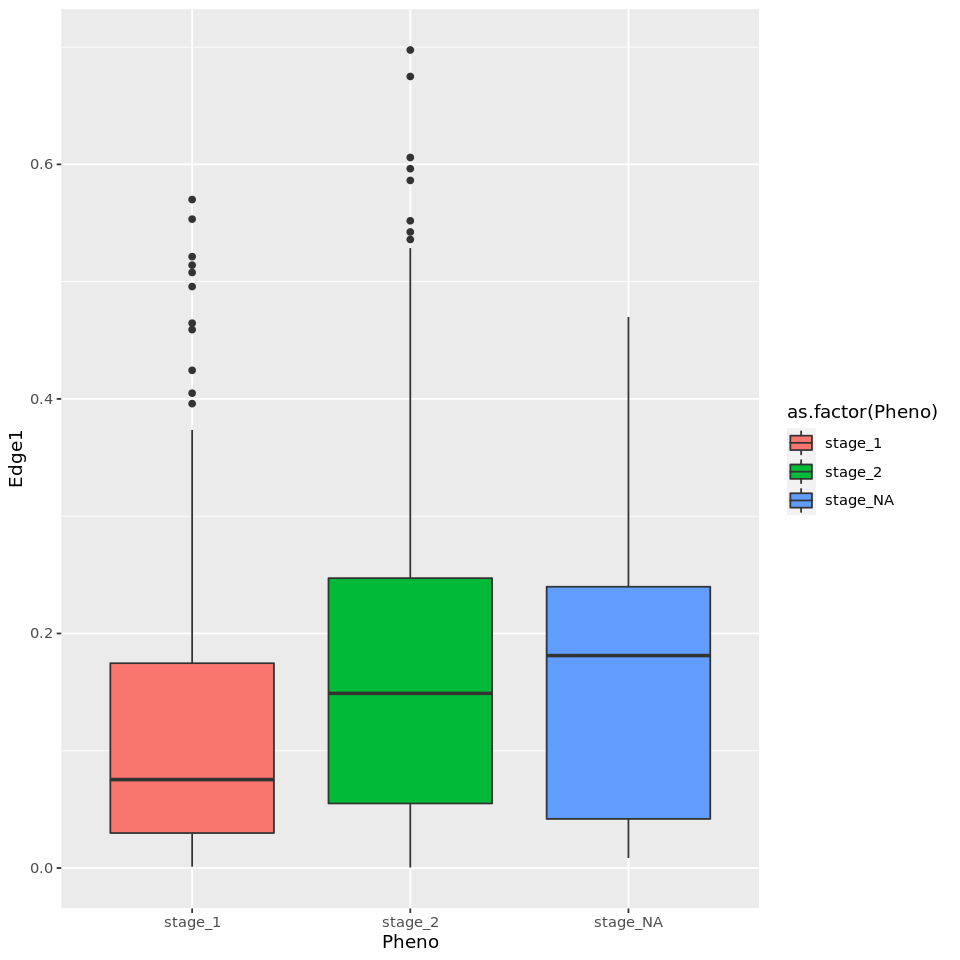

In [37]:

plotdat <- data.frame(Pheno=labels, Edge1=as.numeric(datmat[,5] %>% pull()))
head(plotdat)
qplot(data=plotdat, x=Pheno, y=Edge1, geom='boxplot', fill=as.factor(Pheno))
median(as.numeric(plotdat$Edge1[plotdat$Pheno == 1]), na.rm = T)  - median(as.numeric(plotdat$Edge1[plotdat$Pheno == 2]), na.rm = T)


In [38]:

# data prep #
x <- as.data.frame(datmat[,-1])     # 
x$Phenotype <- labels             # probably don't need this since it goes to factor
x <- x[x$Phenotype != 'stage_NA', ] # remove NAs
colnames(x) <- c(sapply(colnames(x)[1:(ncol(x)-1)], function(a) paste0('edge_',a)), 'Phenotype')
x$Phenotype <- as.factor(x$Phenotype)
x[is.na(x)] <- 0
                        

In [39]:
x[1:5,1:5]
dim(x)
head(labels)
head(x$Phenotype)

,edge_43832,edge_104070,edge_104082,edge_106036,edge_106206
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.008308464,0.016706987,0.038357641,0.001586048,0.033104214
2,0.219954617,0.228908681,0.130950252,0.146316673,0.191051285
3,0.415656435,0.020073204,0.137426644,0.183652387,0.056683363
4,0.090377496,0.009920481,0.008362144,0.030145262,0.075532379
5,0.118196312,0.047237967,0.047597148,0.079606456,0.004640728


[1] 365 242

TCGA-3M-AB46 TCGA-3M-AB47 TCGA-B7-5816 TCGA-B7-5818 TCGA-B7-A5TI TCGA-B7-A5TJ 
   "stage_1"    "stage_2"    "stage_1"    "stage_1"    "stage_2"    "stage_1"

[1] stage_1 stage_2 stage_1 stage_1 stage_2 stage_1
Levels: stage_1 stage_2

In [40]:

xmat <- as.matrix(x[,-ncol(x)])
ylab <- as.numeric(x$Phenotype)-1

head(ylab)


[1] 0 1 0 0 1 0

[1] 241 241

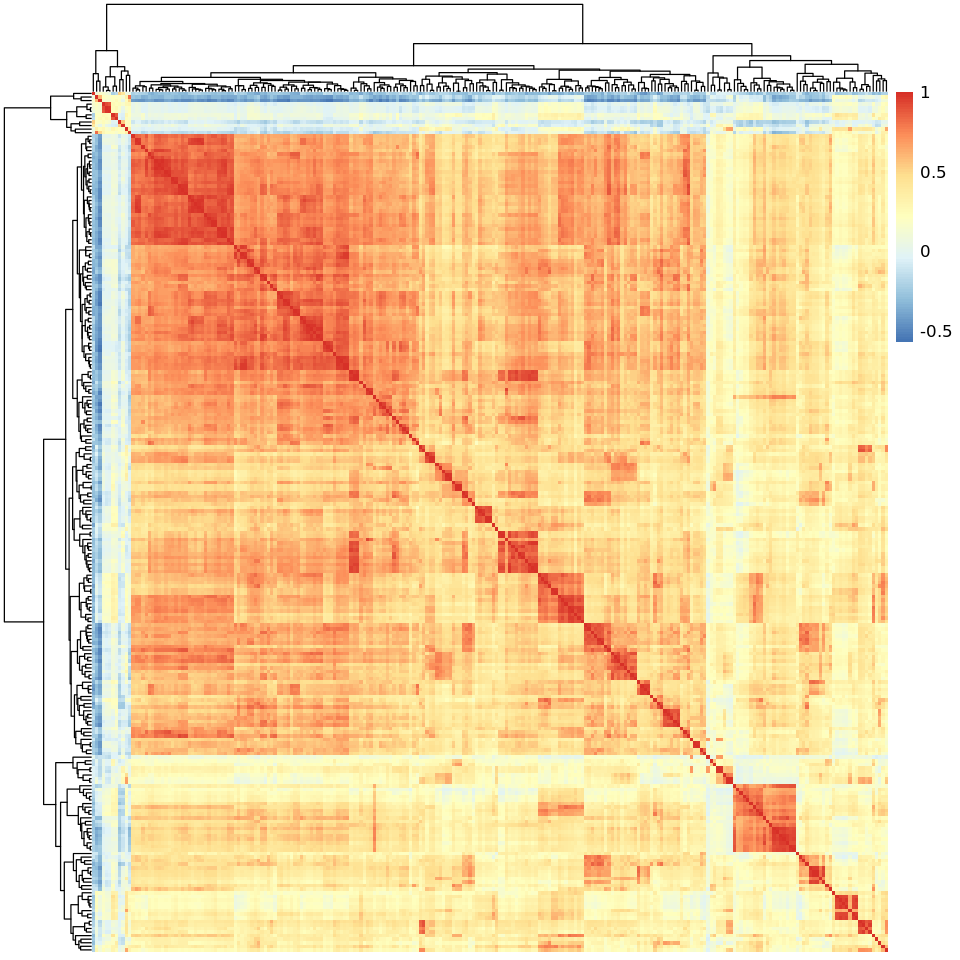

In [41]:
options(repr.plot.width=8, repr.plot.height=8)

xcor <- cor(xmat, method='spearman')
dim(xcor)
pheatmap::pheatmap(xcor, show_rownames = F, show_colnames = F)

In [42]:
# modeling the within data assocations

library(xgboost)

dtrain <- xgboost::xgb.DMatrix(xmat, label=ylab)

param <- list(max_depth = 2, eta = 0.2, nthread = 2,
                objective = "binary:logistic", eval_metric = "auc")

mod <- xgboost::xgboost(data=dtrain, params = param, nrounds=100, early_stopping_rounds = 2)

pred <- predict(mod, xmat)

restab <- table(pred > 0.5, ylab)

head(xgboost::xgb.importance(model = mod), n=10)

restab
acc <- (restab[1,1]+restab[2,2]) / sum(restab)
acc


[1]	train-auc:0.705044 
Will train until train_auc hasn't improved in 2 rounds.

[2]	train-auc:0.760781 
[3]	train-auc:0.786306 
[4]	train-auc:0.796226 
[5]	train-auc:0.807552 
[6]	train-auc:0.819482 
[7]	train-auc:0.834815 
[8]	train-auc:0.850572 
[9]	train-auc:0.866978 
[10]	train-auc:0.880905 
[11]	train-auc:0.894287 
[12]	train-auc:0.905553 
[13]	train-auc:0.907337 
[14]	train-auc:0.915018 
[15]	train-auc:0.918496 
[16]	train-auc:0.926299 
[17]	train-auc:0.927630 
[18]	train-auc:0.935795 
[19]	train-auc:0.941450 
[20]	train-auc:0.946652 
[21]	train-auc:0.954364 
[22]	train-auc:0.957539 
[23]	train-auc:0.962167 
[24]	train-auc:0.966915 
[25]	train-auc:0.968185 
[26]	train-auc:0.972298 
[27]	train-auc:0.976199 
[28]	train-auc:0.977379 
[29]	train-auc:0.980584 
[30]	train-auc:0.982550 
[31]	train-auc:0.984395 
[32]	train-auc:0.985907 
[33]	train-auc:0.987177 
[34]	train-auc:0.989536 
[35]	train-auc:0.989627 
[36]	train-auc:0.989808 
[37]	train-auc:0.991109 
[38]	train-auc:0.991472 
[3

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
edge_128412,0.05708224,0.04434539,0.034825871
edge_43832,0.03614826,0.02436818,0.029850746
edge_346120,0.03482471,0.01739394,0.009950249
edge_403540,0.03403093,0.01269610,0.029850746
edge_648983,0.03100828,0.02233657,0.024875622
edge_587866,0.02781476,0.02282056,0.014925373
edge_106206,0.02348698,0.02059151,0.014925373
edge_903715,0.02322432,0.04148536,0.029850746
edge_333140,0.02284506,0.02532838,0.019900498


       ylab
          0   1
  FALSE 166   0
  TRUE    1 198

[1] 0.9972603

In [43]:
imptab <- xgboost::xgb.importance(model = mod)
colnames(imptab)[1] <- 'EdgeID'

edges <- as.numeric( str_replace_all(imptab$EdgeID, 'edge_', '') )
imptab$EdgeID <- edges

top_edges <- dat %>% dplyr::filter(EdgeID %in% edges) %>% 
  dplyr::select(Study, EdgeID, LCell, Ligand, Receptor, RCell, S1, med_diff) %>% 
  dplyr::group_by(Study, EdgeID, LCell, Ligand, Receptor, RCell) %>% 
  dplyr::summarize(S1avg = mean(S1), med_diff_avg=mean(med_diff)) 


top_edges <- dplyr::inner_join(top_edges, imptab) 
top_edges <- top_edges %>% arrange(desc(Gain))
top_edges

#colnames(top_edges)[9] <- 'imp'
#top_edges %>% dplyr::arrange(desc(imp))

Joining, by = "EdgeID"



Study,EdgeID,LCell,Ligand,Receptor,RCell,S1avg,med_diff_avg,Gain,Cover,Frequency
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
STAD,128412,CD4+ Tem,CALM1,KCNQ1,Macrophages,0.1399113,0.05835853,0.05708224,0.044345387,0.034825871
STAD,43832,astrocytes,FBN1,ITGB6,Epithelial cells,-0.1457411,-0.05817018,0.03614826,0.024368179,0.029850746
STAD,346120,Epithelial cells,LAMB1,ITGAV,Hepatocytes,-0.1387362,-0.06563388,0.03482471,0.017393936,0.009950249
STAD,403540,Hepatocytes,SHH,PTCH1,CD8+ T-cells,-0.1384792,-0.06887380,0.03403093,0.012696095,0.029850746
STAD,648983,Mesangial cells,FGB,ITGAV,Megakaryocytes,-0.1396770,-0.06040992,0.03100828,0.022336567,0.024875622
STAD,587866,Megakaryocytes,TF,TFRC,HSC,-0.1665003,-0.07234356,0.02781476,0.022820560,0.014925373
STAD,106206,CD4+ T-cells,CALM1,SCN10A,Memory B-cells,-0.1381669,-0.06997394,0.02348698,0.020591506,0.014925373
STAD,903715,Platelets,HSPG2,ITGB1,Megakaryocytes,-0.1462670,-0.07053101,0.02322432,0.041485356,0.029850746
STAD,333140,Eosinophils,GS,ADCY7,Megakaryocytes,-0.1398938,-0.05629763,0.02284506,0.025328383,0.019900498


In [44]:
dim(x)
dim(top_edges)

[1] 365 242

[1] 114  11

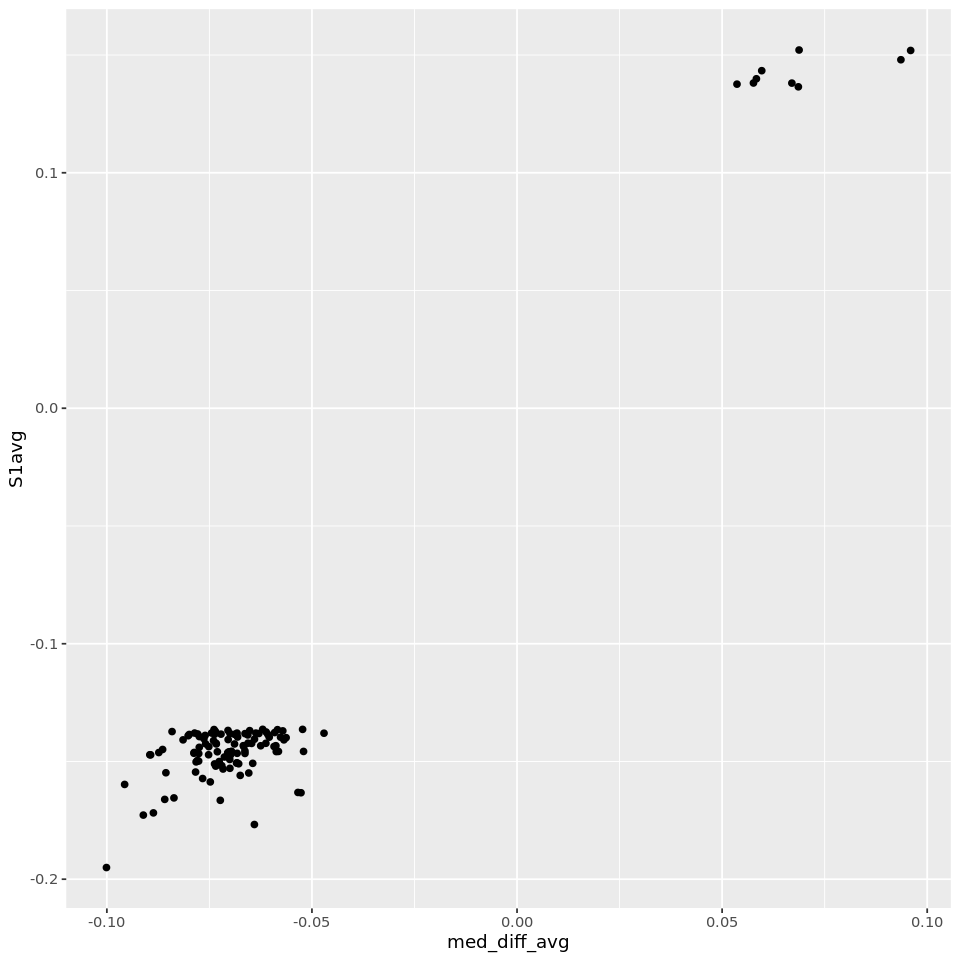

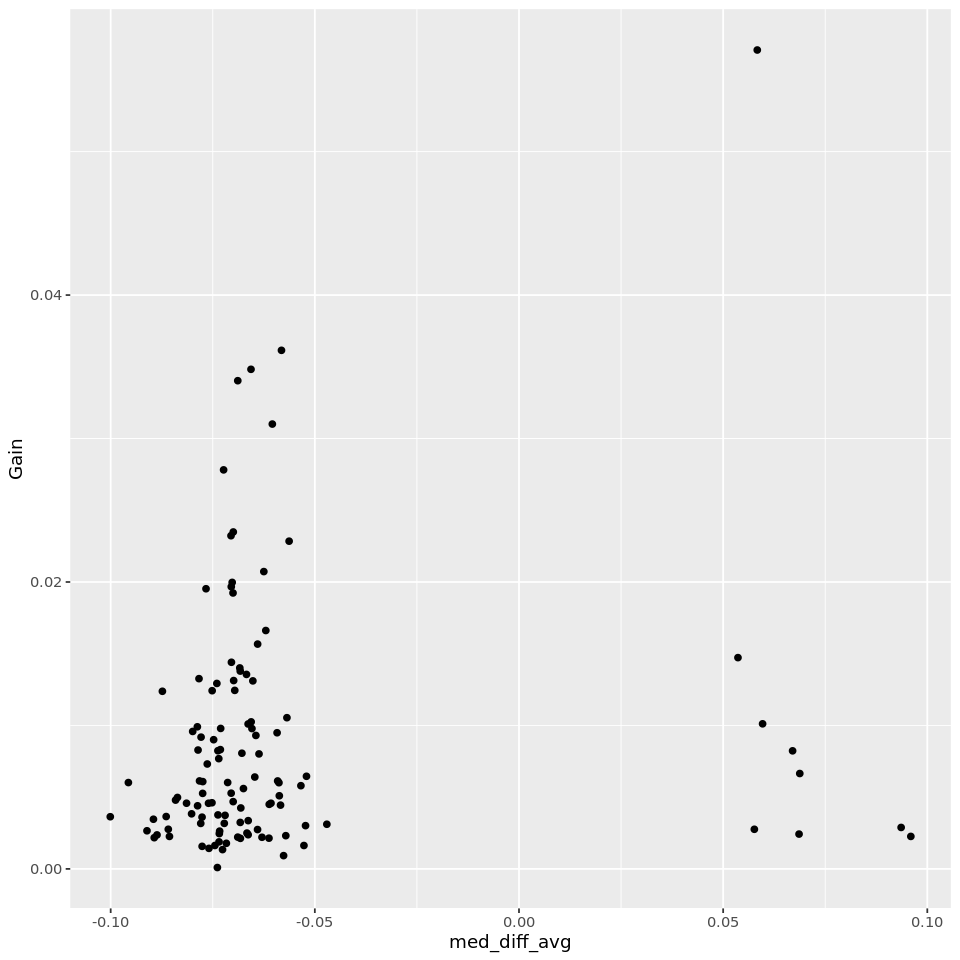

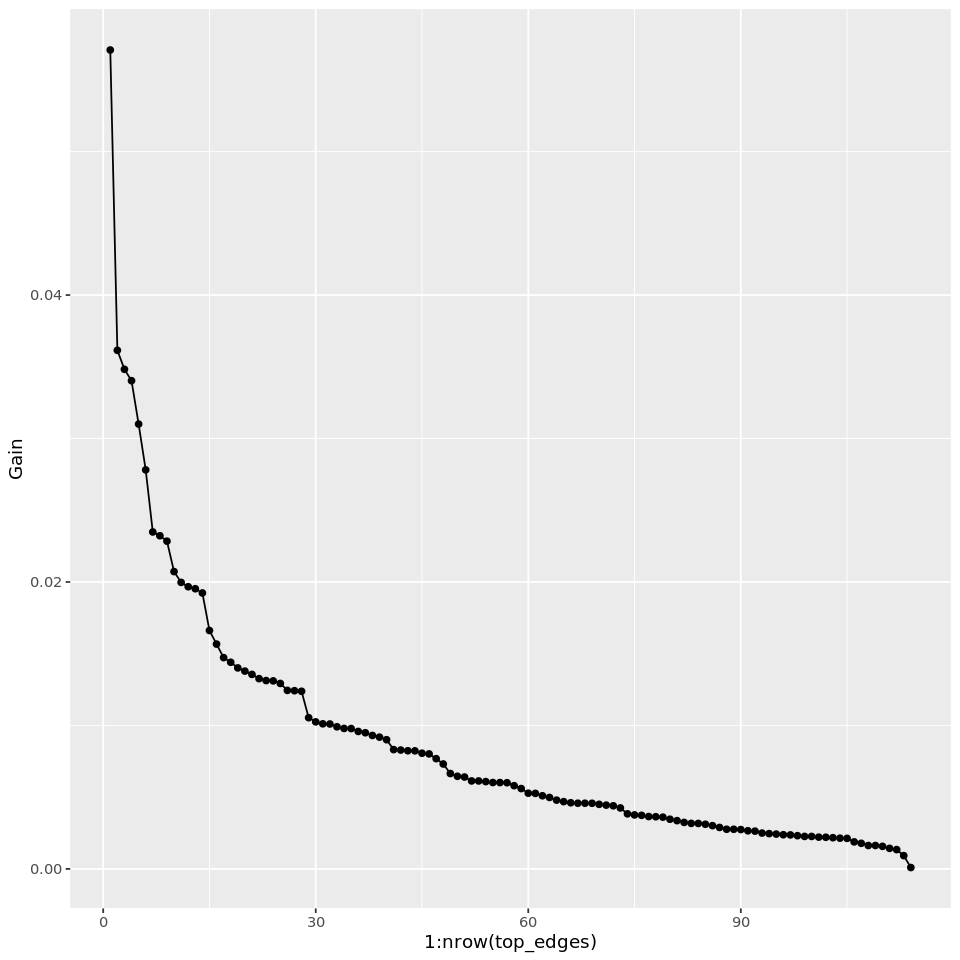

In [45]:
options(repr.plot.width=8, repr.plot.height=8)

qplot(x=med_diff_avg, y=S1avg, data=top_edges)
qplot(x=med_diff_avg, y=Gain, data=top_edges)
qplot(x=1:nrow(top_edges), y=Gain, data=top_edges, geom=c('point', 'line'))

In [46]:
res0 <- unique(top_edges[,c('LCell','RCell','Gain')])
res0 <- res0 %>% group_by(LCell, RCell) %>% mutate(Gain=sum(Gain))
res1 <- matrix(data=as.matrix(res0[,c(1,2)]), ncol = 2, byrow = F)
g <- graph_from_data_frame(res1, directed = T)
g <- set_edge_attr(g, "weight", value = res0$Gain) 

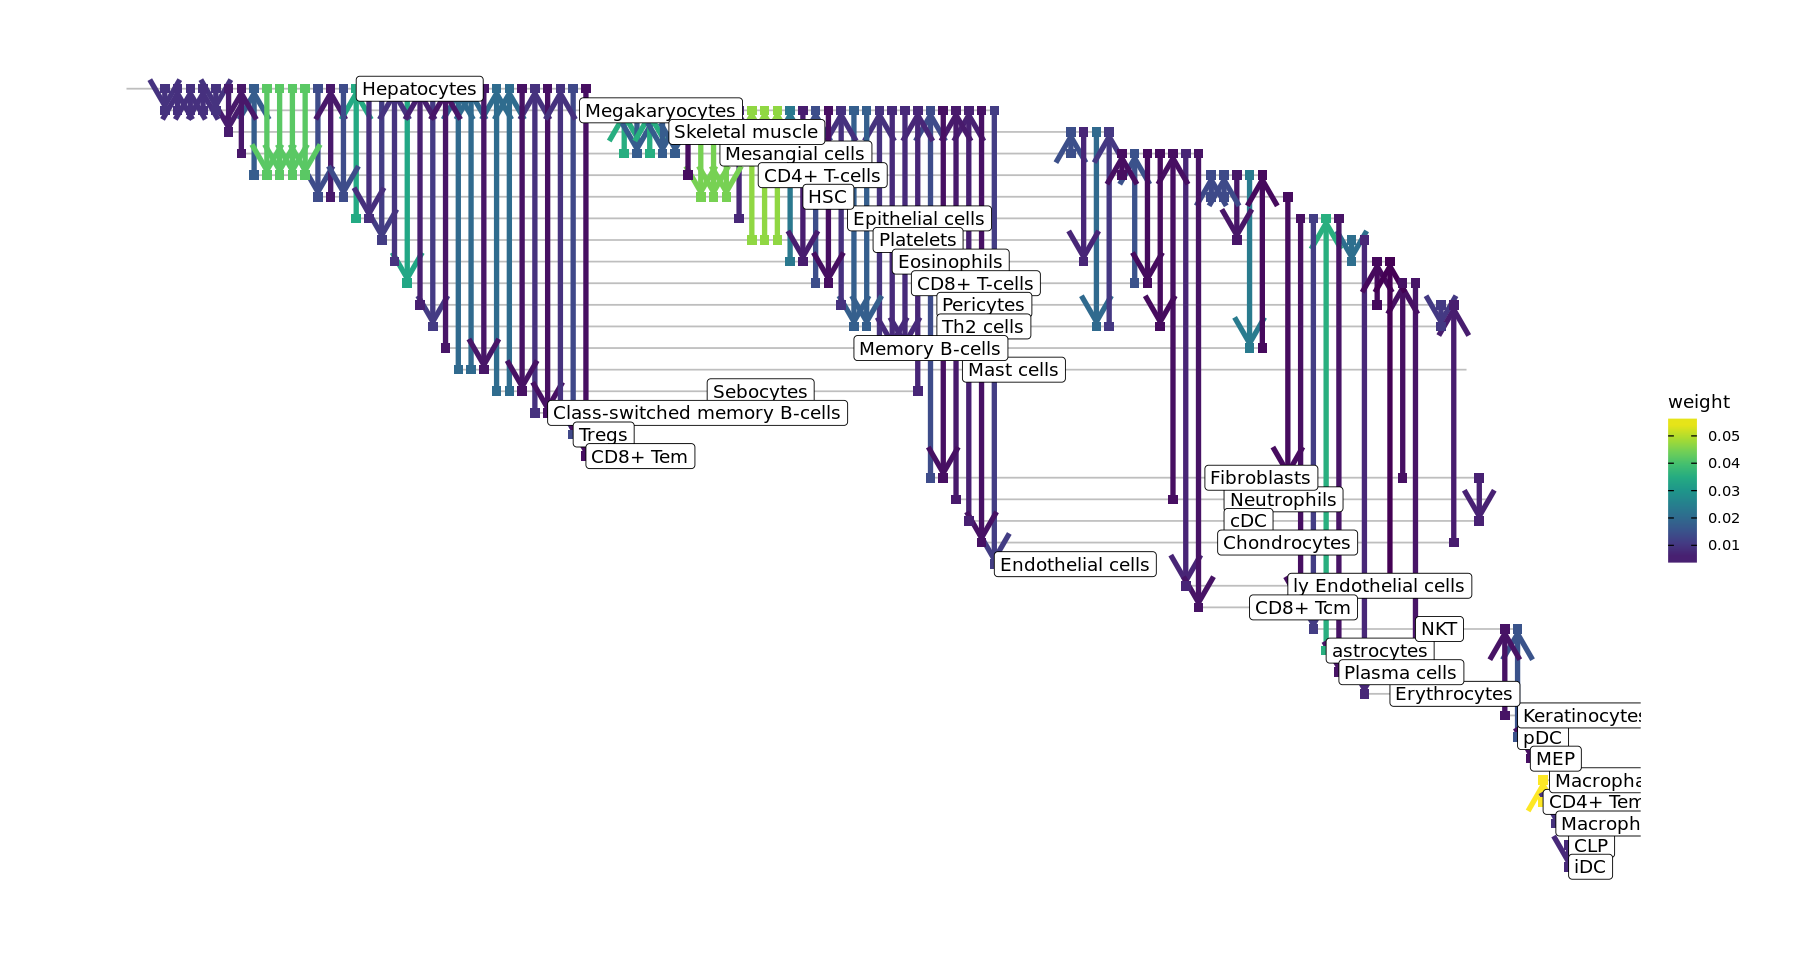

In [47]:

options(repr.plot.width=15, repr.plot.height=8)

ggraph(g, layout='fabric', sort.by = node_rank_fabric()) +
  geom_node_range(colour = 'grey') +
  geom_edge_span(end_shape = 'square', edge_width=1.5, mapping = aes(colour=weight),  arrow = arrow(), end_cap = circle(0.1, 'cm')) + #end_cap = circle(1.0, 'cm'),
  scale_edge_colour_viridis() +
  theme_graph() +
  geom_node_label(aes(label = name), hjust = 0, nudge_x = -0)

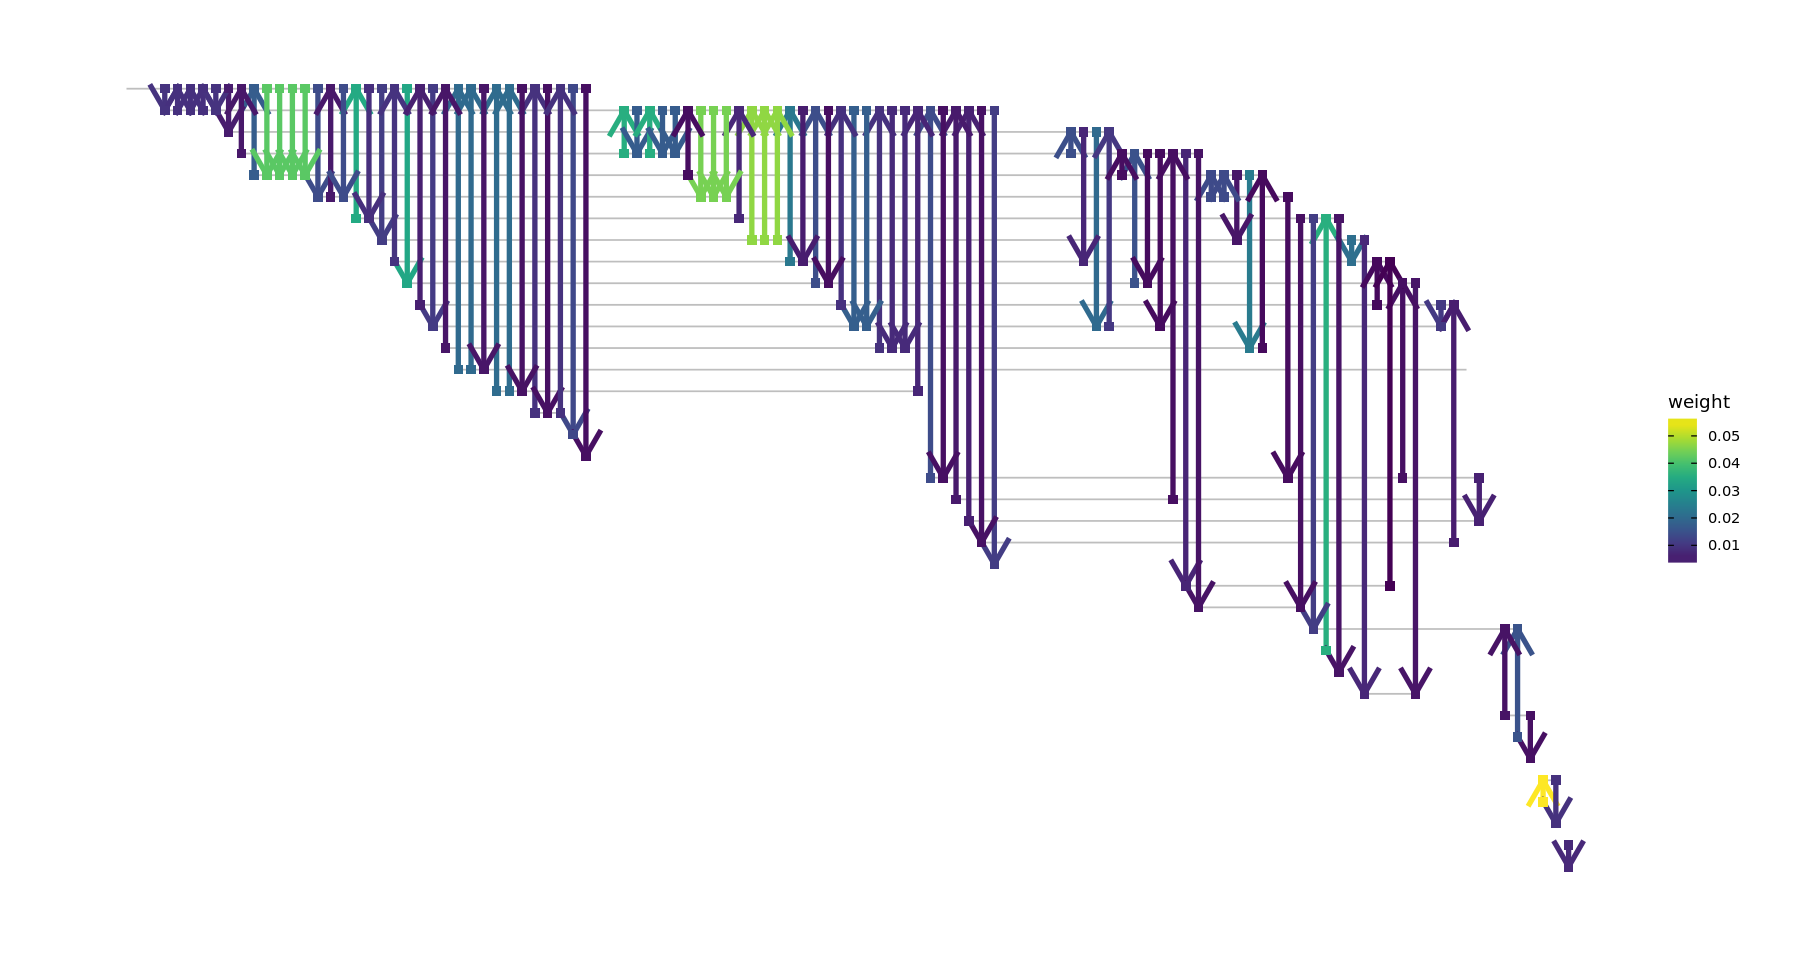

In [48]:
options(repr.plot.width=15, repr.plot.height=8)

ggraph(g, layout='fabric', sort.by = node_rank_fabric()) +
  geom_node_range(colour = 'grey') +
  geom_edge_span(end_shape = 'square', edge_width=1.5, mapping = aes(colour=weight), arrow = arrow()) + #end_cap = circle(1.0, 'cm'), 
  scale_edge_colour_viridis() +
  theme_graph() 